# Part 1 of NNL's Neutworks 

In [1]:
# import library
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import sklearn

## Import datasets 

In [2]:
results = pd.read_csv("../data/results.csv")
ranking = pd.read_csv("../data/fifa_ranking-2023-07-20.csv")

#### Display datasets 

In [3]:
results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45100 entries, 0 to 45099
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        45100 non-null  object
 1   home_team   45100 non-null  object
 2   away_team   45100 non-null  object
 3   home_score  45100 non-null  int64 
 4   away_score  45100 non-null  int64 
 5   tournament  45100 non-null  object
 6   city        45100 non-null  object
 7   country     45100 non-null  object
 8   neutral     45100 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.8+ MB


In [5]:
ranking.head(5)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [6]:
ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64757 entries, 0 to 64756
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             64757 non-null  int64  
 1   country_full     64757 non-null  object 
 2   country_abrv     64757 non-null  object 
 3   total_points     64757 non-null  float64
 4   previous_points  64757 non-null  float64
 5   rank_change      64757 non-null  int64  
 6   confederation    64757 non-null  object 
 7   rank_date        64757 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.0+ MB


## Preprocess

First and foremost, given the fact that some country names have evolved over time, while others no longer exists, it's crucial to alter the data by replacing these instances with accurately updated country names.

We have opted to use OpenAI's GPT-4, with a finely-tuned prompt, to evaluate the " false countries " in the dataset and suggest appropriate replacements. After a series of trials and errors, the following prompt has been perfected to yield optimal results :

```python
prompt = f"""
You will be presented with a list of countries. These could either still exist, have ceased to exist, or be listed in a different language. We refer to these as the "false countries." \
Your task is to generate a JSON where the keys represent these "false countries," and the corresponding values indicate the current, correct English name.
"""
```
The goal of this approach is to maintain a dataset consisting solely of accurate English country names.

#### 1. Replace old countries name by the most precise name

##### 1.1. Replacing country names in `result` dataset

In [7]:
# the JSON file converted to a dictionary returned by CHATGPT-4

false_countries = {
"Czechoslovakia": "Czech Republic", "Catalonia": "Spain","Basque Country": "Spain","Brittany": "France","Yugoslavia": "Serbia","Galicia": "Spain","Andalusia": "Spain","Central Spain": "Spain","Silesia": "Poland","Manchukuo": "China","German DR": "Germany","Kernow": "United Kingdom","Saarland": "Germany", "Vietnam Republic": "Vietnam","North Vietnam": "Vietnam","Zanzibar": "Tanzania","Eswatini": "Swaziland","Western Australia": "Australia","Northern Cyprus": "Cyprus","Yemen DPR": "Yemen","Ynys Môn": "United Kingdom","Shetland": "United Kingdom","Isle of Wight": "United Kingdom","Canary Islands": "Spain",
"Frøya": "Norway","Hitra": "Norway","Corsica": "France","Saare County": "Estonia","Rhodes": "Greece","Orkney": "United Kingdom","Sark": "United Kingdom","Alderney": "United Kingdom","Western Isles": "United Kingdom","Falkland Islands": "United Kingdom","Republic of St. Pauli": "Germany","Găgăuzia": "Moldova", "Tibet": "China","Occitania": "France","Sápmi": "Norway","Menorca": "Spain","Provence": "France","Arameans Suryoye": "Syria","Padania": "Italy","Iraqi Kurdistan": "Iraq","Gozo": "Malta","Bonaire": "Netherlands","Western Sahara": "Morocco","Raetia": "Switzerland","Darfur": "Sudan","Tamil Eelam": "Sri Lanka", "Abkhazia": "Georgia","Madrid": "Spain","Ellan Vannin": "Isle of Man","South Ossetia": "Georgia","County of Nice": "France","Székely Land": "Romania","Romani people": "India","Felvidék": "Slovakia","Chagos Islands": "United Kingdom","United Koreans in Japan": "North Korea","Somaliland": "Somalia",
"Western Armenia": "Turkey","Barawa": "Somalia","Kárpátalja": "Ukraine","Yorkshire": "United Kingdom","Matabeleland": "Zimbabwe","Cascadia": "United States","Kabylia": "Algeria","Parishes of Jersey": "Jersey","Chameria": "Albania","Yoruba Nation": "Nigeria","Biafra": "Nigeria","Mapuche": "Chile", "Aymara": "Bolivia","Ticino": "Switzerland","Hmong": "China"
}

In [8]:
# Calculate and display the number of unique countries before and after the replacement

num_unique_countries = len(set(results["home_team"].unique()) | set(results["away_team"].unique()))
print(f"Number of countries before the replacement : {num_unique_countries}")

results.replace(false_countries, inplace=True)

num_unique_countries = len(set(results["home_team"].unique()) | set(results["away_team"].unique()))
print(f"Number of countries after the replacement : {num_unique_countries}")

Number of countries before the replacement : 317


Number of countries after the replacement : 244


##### 1.2. Replacing country names in `ranking` dataset

We modified the prompt to adapt it to this dataset.


```python
prompt = f"""
Instructions:

You are a prompt engineer specializing in modern geography and country names, as well as football (soccer). Your task is to process a list of countries provided in various languages. Some of these countries may have specific conditions or requirements that need to be addressed. Here are the instructions to be followed:

1. You will receive a list of countries in different languages.
2. Some of these countries may no longer exist, have different names, appear multiple times in different formats, be in a non-simplified form (e.g., IR Iran instead of Iran), or not have a national football team.
3. These countries will be referred to as "false countries."
4. Your output should be in JSON format, where each key represents a "false country," and its corresponding value indicates the correct actual name in English.
5. If a "false country" doesn't have a national football team, its value in the JSON should be "None."

Please ensure that your response strictly adheres to the provided instructions and only includes the requested JSON output.
"""
```

In [9]:
# JSON converted to dictionary that CHATGPT-4 returned with the previous prompt.
false_countries = {
"Korea DPR": "North Korea", "Cape Verde Islands": "Cape Verde","Brunei Darussalam": "Brunei","USA": "United States","Côte d'Ivoire": "Ivory Coast","Yugoslavia": "Serbia","Czechoslovakia": "Czech Republic","Zaire": "Democratic Republic of the Congo","IR Iran": "Iran","China PR": "China", "Trinidad and Tobago": "Trinidad","Korea Republic": "South Korea","FYR Macedonia": "North Macedonia","Kyrgyz Republic": "Kyrgyzstan","Chinese Taipei": "Taiwan","Serbia and Montenegro": "Serbia","Swaziland": "Eswatini","St. Vincent / Grenadines": "St. Vincent and the Grenadines", "Timor-Leste": "East Timor","North Macedonia": "Macedonia","São Tomé e Príncipe": "Sao Tome and Principe","Curaçao": "Curacao","Cabo Verde": "Cape Verde","Czechia": "Czech Republic","Türkiye": "Turkey","St Vincent and the Grenadines": "St. Vincent and the Grenadines", "St Lucia": "St. Lucia","The Gambia": "Gambia","St Kitts and Nevis": "St. Kitts and Nevis","Hong Kong, China": "Hong Kong","Aotearoa New Zealand": "New Zealand"
}

In [10]:
# Calculate and display the number of unique countries before and after the replacement

num_unique_countries = len(ranking["country_full"].unique())
print(f"Number of countries before the replacement : {num_unique_countries}")

ranking.replace(false_countries, inplace=True)

num_unique_countries = len(ranking["country_full"].unique())
print(f"Number of countries after the replacement : {num_unique_countries}")

Number of countries before the replacement : 231
Number of countries after the replacement : 216


#### 1.3. Choosing a cutting year

After careful consideration, we have decided to choose a "cut-off year" based on our project's performance rather than changes in country names.
We deem the data prior to 2000 as mostly irrelevant as it does not significantly influence current game results because:

- Matches from that era do not contribute to today's game outcomes, mainly due to their age.

- There have been considerable changes in the game dynamics and player preparation over the years. As a result, comparisons between past and present matches are not highly meaningful.

- The structure of competitions has undergone numerous transformations. Therefore, team performances from the past may not accurately reflect their current capabilities.

Once we implement this initial cut-off, we will further fine-tune the "cut-off year" to refine our results.

#### 1.3.1. Convert databases' date columns from String to DateTime

In [11]:
# Convert "date columns"  of datasets to date time type

results['date']         = pd.to_datetime(results['date'], format='%Y-%m-%d') 
ranking['rank_date']    = pd.to_datetime(ranking['rank_date'], format='%Y-%m-%d') 

#### 1.3.2. Drop data before 01/01/2000

In [12]:
results = results[results['date'].dt.year >= 2000]
ranking = ranking[ranking['rank_date'].dt.year >= 2000]

In [13]:
# Ensure that the result is as expected
print(results.head(2))
print("*"*90)
print(ranking.head(2))

            date home_team away_team  home_score  away_score tournament  \
22807 2000-01-04     Egypt      Togo           2           1   Friendly   
22808 2000-01-07   Tunisia      Togo           7           0   Friendly   

        city  country  neutral  
22807  Aswan    Egypt    False  
22808  Tunis  Tunisia    False  
******************************************************************************************
       rank  country_full country_abrv  total_points  previous_points  \
12119   138     St. Lucia          LCA         214.0            174.0   
12120   130  Turkmenistan          TKM         251.0            251.0   

       rank_change confederation  rank_date  
12119          -14      CONCACAF 2000-01-19  
12120            1           AFC 2000-01-19  


### 2. Resempling Data

#### 2.1. Resetting indexs

The dataset containing results will be indexed based solely on dates, while the dataset for ranking will also be indexed by the names of countries to assist with resampling.

In [14]:
results.set_index(['date'], inplace=True)
ranking.set_index(['rank_date', 'country_full'], inplace=True)

In [15]:
print(f"Results's index  : {results.index.names}")
print(f"Ranking's indexs : {ranking.index.names}")

Results's index  : ['date']
Ranking's indexs : ['rank_date', 'country_full']


#### 2.2. Grouping ranking datas by date and country's name.

In [16]:
# Grouping by date and country name
grouped_ranking = ranking.groupby(by=['rank_date', 'country_full']).ffill()
grouped_ranking

rank country_abrv  total_points  \
rank_date  country_full                                         
2000-01-19 St. Lucia           138          LCA        214.00   
           Turkmenistan        130          TKM        251.00   
           Bangladesh          131          BAN        247.00   
           Sudan               132          SDN        244.00   
           Burundi             133          BDI        238.00   
...                            ...          ...           ...   
2023-07-20 Cape Verde           66          CPV       1354.65   
           Iceland              67          ISL       1352.98   
           Macedonia            68          MKD       1350.53   
           Jamaica              58          JAM       1409.73   
           US Virgin Islands   205          VIR        816.59   

                              previous_points  rank_change confederation  
rank_date  country_full                                                   
2000-01-19 St. Lucia                   174.00          -14      CONCACAF  
           Turkmenistan                251.00            1           AFC  
           Bangladesh                  247.00            1           AFC  
           Sudan                       244.00            0           CAF  
           Burundi                     239.00            0           CAF  
...                                       ...          ...           ...  
2023-07-20 Cape Verde                 1354.65            0           CAF  
           Iceland                    1352.98            0          UEFA  
           Macedonia                  1350.53            0          UEFA  
           Jamaica                    1367.83           -5      CONCACAF  
           US Virgin Islands           816.59           -3      CONCACAF  

[52638 rows x 6 columns]

#### 2.3. Upsampling

In [17]:
# Reset Ranking's indexs for the upsampling
grouped_ranking.reset_index(inplace=True)
grouped_ranking.set_index("rank_date", inplace=True)


In [18]:
# An example to observe the impact of upsampling on our dataset
count_france_lines = len(grouped_ranking.loc[grouped_ranking['country_full'] == "France"])
print(f"Count lines where France appears before the upsamling : {count_france_lines}")

# For each country, we create a sub-dataset. We upsample it by day, assign the latest non-null values to each date, 
# and add new rows to `sampled_ranking`, which represents the final dataset.
list_of_countries   = grouped_ranking["country_full"].unique()
sampled_ranking     = pd.DataFrame()

for country in list_of_countries:
    
    df_country      = grouped_ranking[grouped_ranking['country_full'] == country].copy()
    df_country      = df_country.resample("D").last().ffill()
    sampled_ranking = pd.concat([sampled_ranking, df_country], axis=0)
    
sampled_ranking     = sampled_ranking.sort_index()
count_france_lines  = len(sampled_ranking.loc[sampled_ranking['country_full'] == "France"])

print(f"Count lines where France appears after the upsamling : {count_france_lines}")

Count lines where France appears before the upsamling : 258


Count lines where France appears after the upsamling : 8584


### 3. Merging datasets

In [19]:
# Reset datasets' indexs for the merging
sampled_ranking.reset_index(inplace=True)
results.reset_index(inplace=True)

#### 3.1. First merging on home team

In [20]:
# Merging results with sampled_ranking on home team
sampled_ranking.columns = [col + "_home" if col != "rank_date" and col != "country_full" 
                                         else col for col in sampled_ranking.columns]
rera                    = results.merge(sampled_ranking, 
                                        left_on     =["date", "home_team"], 
                                        right_on    =["rank_date", "country_full"], 
                                        suffixes    =[None,'_home']).drop(["rank_date","country_full", "country_abrv_home"],
                                        axis        =1)

#### 3.2. Second merging on away team

In [21]:
# Merging results with sampled_ranking on away team
sampled_ranking.columns = [col.replace("_home", "_away") for col in sampled_ranking.columns]
rera                    = rera.merge(sampled_ranking, 
                                     left_on   =["date", "away_team"], 
                                     right_on  =["rank_date", "country_full"], 
                                     suffixes  =[None,'_away']).drop(["rank_date","country_full", "country_abrv_away"],
                                     axis      =1)

#### 3.3 Observe results from the merging

In [22]:
rera.sort_values(by='date', inplace=True)
rera.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_home,total_points_home,previous_points_home,rank_change_home,confederation_home,rank_away,total_points_away,previous_points_away,rank_change_away,confederation_away
0,2000-01-19,Panama,Guatemala,2,0,Friendly,Panama City,Panama,False,139.0,214.0,214.0,1.0,CONCACAF,73.0,454.0,453.0,0.0,CONCACAF
1,2000-01-19,Togo,Egypt,1,0,Friendly,Lomé,Togo,False,87.0,413.0,416.0,0.0,CAF,38.0,558.0,556.0,0.0,CAF
2,2000-01-20,Burkina Faso,Algeria,1,0,Friendly,Ouagadougou,Burkina Faso,False,74.0,453.0,456.0,3.0,CAF,86.0,421.0,422.0,0.0,CAF
3,2000-01-20,Malta,Qatar,2,0,Friendly,Attard,Malta,False,116.0,308.0,309.0,0.0,UEFA,107.0,357.0,357.0,0.0,AFC
4,2000-01-21,New Zealand,South Korea,0,1,Friendly,Auckland,New Zealand,False,100.0,381.0,381.0,0.0,OFC,52.0,522.0,522.0,1.0,AFC


### 4. Altering features

In [23]:
rera.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19460 entries, 0 to 19459
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  19460 non-null  datetime64[ns]
 1   home_team             19460 non-null  object        
 2   away_team             19460 non-null  object        
 3   home_score            19460 non-null  int64         
 4   away_score            19460 non-null  int64         
 5   tournament            19460 non-null  object        
 6   city                  19460 non-null  object        
 7   country               19460 non-null  object        
 8   neutral               19460 non-null  bool          
 9   rank_home             19460 non-null  float64       
 10  total_points_home     19460 non-null  float64       
 11  previous_points_home  19460 non-null  float64       
 12  rank_change_home      19460 non-null  float64       
 13  confederation_home   

#### 4.1. New Features

##### 4.1.1. A `winner` feature

`winner` will be an integer column, containing only three distinct values: `{0, 1, 2}`.
- `0`: Indicates that the `home_team` has won.
- `1`: Indicates that the `away_team` has won.
- `2`: Represents a draw, signifying that both teams have an equal outcome.

In [24]:
# Function to define a winner
def define_winner(line) :
    
    if rera.loc[line.name, "home_score"] > rera.loc[line.name, "away_score"]:
         return 0
    
    elif rera.loc[line.name, "home_score"] < rera.loc[line.name, "away_score"]:
        return 1
    
    else :
        return 2

In [25]:
# Create winner column and defining winners of each match
rera['winner'] = rera.apply(lambda line : define_winner(line), axis=1)

###### 4.1.1.1. Draw matches issue

In the case of a draw, we will update the `winner` column with the results of the shootouts data. If the `shootout` column is `NaN`, we will drop the row. Since our model has to predict the outcome of a match, with a binary output, we cannot have draws in our dataset.

###### 4.1.1.2. Drop all friendly matches from the dataset that where draw

First we need to drop all friendly draw machs from the dataset. Since we don't have the shootouts results for friendly matches.

In [26]:
print(len(rera[rera['winner'] == 2]))

rera = rera.drop(rera[(rera['tournament'] == "Friendly") & (rera['winner'] == 2)].index)

print(len(rera[rera['winner'] == 2]))

4628
2774


###### 4.1.1.3. Updating winner of draw matches with the shootouts results

Now we can import the shootouts dataset and update the `winner` column by comparing the `shootout` dataset with the `date`, `home_team` and `away_team` columns of the `rera` dataset.

In [27]:
# Import shootouts dataset
shootouts         = pd.read_csv("../data/shootouts.csv")
shootouts['date'] = pd.to_datetime(shootouts['date'], format='%Y-%m-%d')

# For each row in rera that has a draw, look for the corresponding match in shootouts,
# And then update the winner column.

for index, row in rera.iterrows():

    if row['winner'] == 2:
        
        shootout = shootouts.loc[(shootouts['date']         == row['date'])         &
                                 (shootouts['home_team']    == row['home_team'])    & 
                                 (shootouts['away_team']    == row['away_team'])]
        
        if len(shootout) > 0:
            
            # Update the winner column as so :
            # If the home team won the shootout the winner is 0 else the winner is 1
            
            #print(row['date'], row['home_team'], row['away_team'], row['winner'], row['tournament'])
            #print('SHOOTOUT', shootout['date'].values[0], shootout['home_team'].values[0], shootout['away_team'].values[0], shootout['winner'].values[0])
            
            if shootout['winner'].values[0] == row['home_team']:
                rera.loc[index, 'winner'] = 0
            else:
                rera.loc[index, 'winner'] = 1

###### 4.1.1.4. Drop all left draw matches from the dataset

In [28]:
print(len(rera[rera['winner'] == 2]))

rera = rera.drop(rera[rera['winner'] == 2].index)

print(len(rera[rera['winner'] == 2]))

2561
0


##### 4.1.2. Average goal feature

We are adding two new features, `home_goals_avg` and `away_goals_avg`. Two columns containing the average number of goals scored by the home/away team in the last 7 matches. 

(Seven matches on average are sufficient to form an idea about the current form of a football team.)

In [29]:
# A Function to compute the average goal of a team on the last 7 matches
# If there is less than 7 matches, we compute the average on the number of matches available
# If there is no match, we return 0

def compute_avg_country_goal(line, country):
    
    # Get the date of the current match and get the 7 previous matches
    date                = line.name
    previous_matches    = rera.loc[(rera['home_team'] == country) | (rera['away_team'] == country)].loc[:date].tail(7)
    
    # If there is no match, we return 0
    if len(previous_matches) == 0:
        return 0
    
    # If there is less than 7 matches, we compute the average on the number of matches available
    elif len(previous_matches) < 7:
        return previous_matches['home_score'].sum() + previous_matches['away_score'].sum() / len(previous_matches)
    
    # If there is 7 matches, we compute the average on the 7 matches
    else:
        return previous_matches['home_score'].sum() + previous_matches['away_score'].sum() / 7

In [30]:
# Create home_goals_avg and away_goals_avg columns and defining the average goal of each team

rera['home_goals_avg'] = rera.apply(lambda line : compute_avg_country_goal(line, line['home_team']), axis=1)
rera['away_goals_avg'] = rera.apply(lambda line : compute_avg_country_goal(line, line['away_team']), axis=1)

In [ ]:
rera.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_home,...,rank_change_home,confederation_home,rank_away,total_points_away,previous_points_away,rank_change_away,confederation_away,winner,home_goals_avg,away_goals_avg
0,2000-01-19,Panama,Guatemala,2,0,Friendly,Panama City,Panama,False,139.0,...,1.0,CONCACAF,73.0,454.0,453.0,0.0,CONCACAF,0,2.0,2.0
1,2000-01-19,Togo,Egypt,1,0,Friendly,Lomé,Togo,False,87.0,...,0.0,CAF,38.0,558.0,556.0,0.0,CAF,0,1.0,1.0
2,2000-01-20,Burkina Faso,Algeria,1,0,Friendly,Ouagadougou,Burkina Faso,False,74.0,...,3.0,CAF,86.0,421.0,422.0,0.0,CAF,0,1.0,1.0


##### 4.1.3. A average win feature

We are adding two new features, `home_win_avg` and `away_win_avg`. Two columns containing the average number of wins of the home/away team in the last 7 matches.

(Seven matches on average are sufficient to form an idea about the current form of a football team.)

In [ ]:
# A Function to compute the average win of a team on the last 7 matches
# If there is less than 7 matches, we compute the average on the number of matches available
# If there is no match, we return 0

def compute_avg_country_win(line, country):
    
    # Get the date of the current match and get the 7 previous matches
    date                = line.name
    previous_matches    = rera.loc[(rera['home_team'] == country) | (rera['away_team'] == country)].loc[:date].tail(7)
    
    # If there is no match, we return 0
    if len(previous_matches) == 0:
        return 0
    
    # If there is less than 7 matches, we compute the average on the number of matches available
    elif len(previous_matches) < 7:
        return previous_matches['winner'].sum() / len(previous_matches)
    
    # If there is 7 matches, we compute the average on the 7 matches
    else:
        return previous_matches['winner'].sum() / 7

In [ ]:
# Create home_win_avg and away_win_avg columns and defining the average win of each team

rera['home_win_avg'] = rera.apply(lambda line : compute_avg_country_win(line, line['home_team']), axis=1)
rera['away_win_avg'] = rera.apply(lambda line : compute_avg_country_win(line, line['away_team']), axis=1)

In [ ]:
rera.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_home,...,rank_away,total_points_away,previous_points_away,rank_change_away,confederation_away,winner,home_goals_avg,away_goals_avg,home_win_avg,away_win_avg
0,2000-01-19,Panama,Guatemala,2,0,Friendly,Panama City,Panama,False,139.0,...,73.0,454.0,453.0,0.0,CONCACAF,0,2.0,2.0,0.0,0.0
1,2000-01-19,Togo,Egypt,1,0,Friendly,Lomé,Togo,False,87.0,...,38.0,558.0,556.0,0.0,CAF,0,1.0,1.0,0.0,0.0
2,2000-01-20,Burkina Faso,Algeria,1,0,Friendly,Ouagadougou,Burkina Faso,False,74.0,...,86.0,421.0,422.0,0.0,CAF,0,1.0,1.0,0.0,0.0


#### 4.2. Dropping useless features

Correlation heatmap and basic statistics on `rera`. Used to have an overview on the relationship between features.

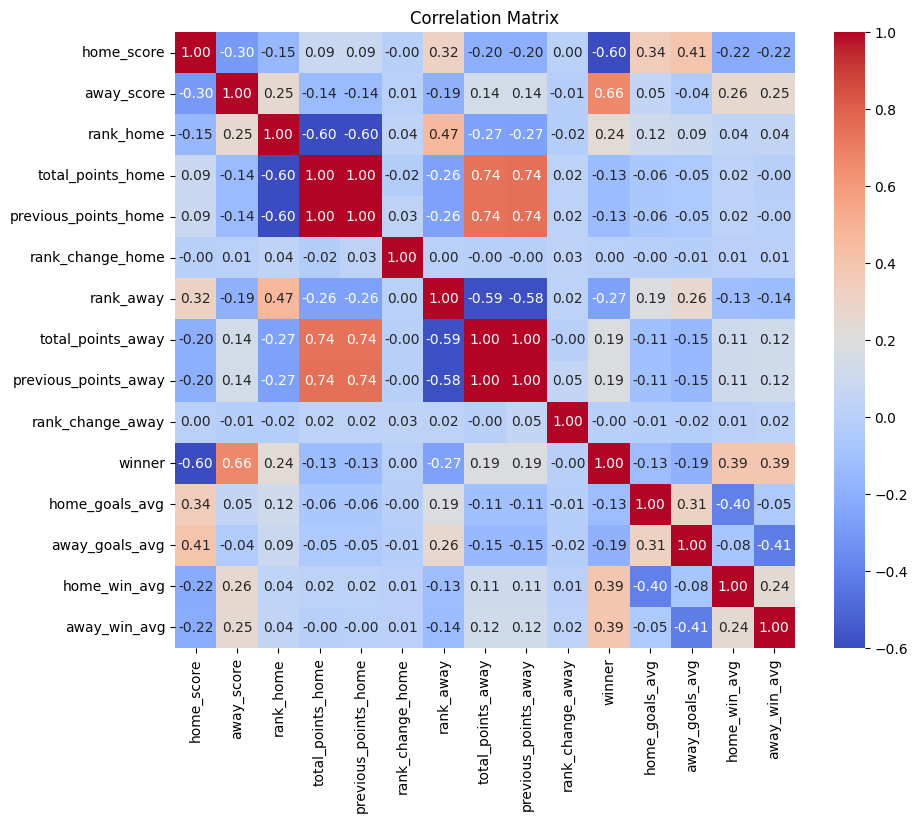

In [ ]:
# Select only numeric columns
numeric_columns = rera.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set plot title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [ ]:
numeric_columns.describe()

,home_score,away_score,rank_home,total_points_home,previous_points_home,rank_change_home,rank_away,total_points_away,previous_points_away,rank_change_away,winner,home_goals_avg,away_goals_avg,home_win_avg,away_win_avg
count,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000
mean,1.806314,1.146162,78.397341,683.059723,682.556276,0.028980,83.551878,658.143702,656.916473,-0.158724,0.373679,13.550508,13.539325,0.371968,0.373498
std,1.714996,1.386003,54.286435,437.966047,437.569529,5.091214,54.985566,433.279300,433.225883,5.382504,0.483796,4.822605,5.052495,0.187109,0.187492
min,0.000000,0.000000,1.000000,2.000000,0.000000,-73.000000,1.000000,2.000000,0.000000,-73.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,31.000000,350.000000,349.000000,-1.000000,37.000000,330.000000,329.000000,-1.000000,0.000000,10.428571,10.285714,0.285714,0.285714
50%,2.000000,1.000000,71.000000,584.000000,584.000000,0.000000,77.000000,558.000000,557.000000,0.000000,0.000000,13.142857,13.000000,0.428571,0.428571
75%,3.000000,2.000000,118.000000,970.000000,967.000000,1.000000,125.000000,940.000000,938.000000,1.000000,1.000000,16.142857,16.142857,0.428571,0.428571
max,31.000000,21.000000,211.000000,2164.000000,2151.000000,62.000000,211.000000,2164.000000,2134.000000,62.000000,1.000000,72.142857,69.857143,1.000000,1.000000


##### 4.2.1. Dropping `city` feature

Having a `city` feature is not relevant to our analysis since we already have `country`. Therefore, we will drop it.

In [ ]:
rera.drop("city", axis=1, inplace=True)

##### 4.2.2. Dropping `home_score` and `away_score` feature

We will drop `home_score` and `away_score` since we already have `winner`, `home_goals_avg` and `away_goals_avg` features.

(The average goal feature is more relevant in the soccer context, since one team can score multiple times against a weaker team but then score nothing against a stronger opponent. It also gives a better overview on the team's performance over the years. Therefor, dropping the score columns will help us to avoid overfitting and misleading the model.)

In [ ]:
rera.drop(["home_score", "away_score"], axis=1, inplace=True)

##### 4.2.3. Dropping `country` feature

Regarding the `country` feature, taking into account the fact that we can already identify the country where the match takes place by looking at `home_team` or `away_team` depending on the value of `neutral` feature, `country` gets redundant. Therefore, we can drop it.

In [ ]:
rera.drop("country", axis=1, inplace=True)

##### 4.2.4. Dropping `previous_points_home` and `previous_points_away` feature

As shown in the correlation heatmap, `previous_points_home` and `previous_points_away` exhibit high correlations with `total_points_home` and `total_points_away`, respectively. Across multiple matches, the total number of points remains relatively constant, possibly accounting for this correlation. We hypothesize that the total points alone provide sufficient information, making the details from `previous_points` redundant, despite its minor fluctuations.

In [ ]:
rera.drop(["previous_points_home", "previous_points_away"], axis=1, inplace=True)

#### 4.3. Tuning features

##### 4.3.1. Encoding String type objects

In [ ]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['home_team', 'away_team', 'confederation_home', 'confederation_away', 'tournament']


label_encoder = LabelEncoder()

for column in columns_to_encode:
    rera[column + '_encoded'] = label_encoder.fit_transform(rera[column])

rera.drop(["home_team", "away_team", "confederation_home", "tournament", "confederation_away"], axis=1, inplace=True)

##### 4.3.1. Dimensionality Reduction: Principal Component Analysis